In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
df = pd.read_csv("weather_features.csv")
df = df[['dt_iso', 'city_name', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_main', 'weather_description', 'weather_id', 'humidity', 'pressure']].copy()
df

,dt_iso,city_name,wind_speed,wind_deg,clouds_all,weather_main,weather_description,weather_id,humidity,pressure
0,2015-01-01 00:00:00+01:00,Valencia,1,62,0,clear,sky is clear,800,77,1001
1,2015-01-01 01:00:00+01:00,Valencia,1,62,0,clear,sky is clear,800,77,1001
2,2015-01-01 02:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002
3,2015-01-01 03:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002
4,2015-01-01 04:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002
...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,3,30,0,clear,sky is clear,800,54,1028
178392,2018-12-31 20:00:00+01:00,Seville,3,30,0,clear,sky is clear,800,62,1029
178393,2018-12-31 21:00:00+01:00,Seville,4,50,0,clear,sky is clear,800,58,1028
178394,2018-12-31 22:00:00+01:00,Seville,4,60,0,clear,sky is clear,800,57,1029


In [3]:
unique_descriptions = df['weather_description'].unique()
unique_ids = df['weather_id'].unique()

print(f"Ukupno ima {len(unique_ids)} različitih idjeva vremena:\n")
print(f"Ukupno ima {len(unique_descriptions)} različitih opisa vremena:\n")
for desc in unique_descriptions:
    print(f"- {desc}")

Ukupno ima 38 različitih idjeva vremena:

Ukupno ima 43 različitih opisa vremena:

- sky is clear
- few clouds
- scattered clouds
- broken clouds
- overcast clouds
- light rain
- moderate rain
- heavy intensity rain
- mist
- heavy intensity shower rain
- shower rain
- very heavy rain
- thunderstorm with heavy rain
- thunderstorm with light rain
- thunderstorm with rain
- proximity thunderstorm
- thunderstorm
- light intensity shower rain
- light intensity drizzle
- fog
- drizzle
- smoke
- heavy intensity drizzle
- haze
- proximity shower rain
- light intensity drizzle rain
- light snow
- rain and snow
- light rain and snow
- snow
- light thunderstorm
- heavy snow
- sleet
- rain and drizzle
- shower sleet
- light shower sleet
- light shower snow
- proximity moderate rain
- ragged shower rain
- sand dust whirls
- proximity drizzle
- dust
- squalls


In [5]:
print(df.columns[df.isnull().any()])

Index([], dtype='object')


In [4]:
df_energy = pd.read_csv("energy_dataset.csv")
df_energy = df_energy[['time', 'generation solar', 'generation wind onshore', 'total load actual']].copy()
df_energy

,time,generation solar,generation wind onshore,total load actual
0,2015-01-01 00:00:00+01:00,49.0,6378.0,25385.0
1,2015-01-01 01:00:00+01:00,50.0,5890.0,24382.0
2,2015-01-01 02:00:00+01:00,50.0,5461.0,22734.0
3,2015-01-01 03:00:00+01:00,50.0,5238.0,21286.0
4,2015-01-01 04:00:00+01:00,42.0,4935.0,20264.0
...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,85.0,3113.0,30653.0
35060,2018-12-31 20:00:00+01:00,33.0,3288.0,29735.0
35061,2018-12-31 21:00:00+01:00,31.0,3503.0,28071.0
35062,2018-12-31 22:00:00+01:00,31.0,3586.0,25801.0


In [5]:
print(df_energy.columns[df_energy.isnull().any()])

Index(['generation solar', 'generation wind onshore', 'total load actual'], dtype='object')


In [6]:
total_rows = len(df_energy)
missing_percentage = (df_energy.isnull().sum() / total_rows) * 100

print("\nProcenat nedostajućih vrednosti:")
print(missing_percentage[missing_percentage > 0].round(2).astype(str) + '%')

df_energy['generation solar'] = df_energy['generation solar'].ffill()
df_energy['generation wind onshore'] = df_energy['generation wind onshore'].ffill()
df_energy['total load actual'] = df_energy['total load actual'].ffill()




Procenat nedostajućih vrednosti:
generation solar           0.05%
generation wind onshore    0.05%
total load actual           0.1%
dtype: object


Moramo osigurati da oba DataFrame-a imaju isto ime kolone za vreme

In [8]:
df_energy = df_energy.rename(columns={'time': 'dt_iso'})

df_energy['dt_iso'] = pd.to_datetime(df_energy['dt_iso'], utc=True)
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True)

Da bismo imali jedan red po satu, moramo raširiti gradove u kolone. Tako ćemo u jednom redu imati temperaturu i vetar za Madrid, Bilbao, Sevilju, Barselonu i Valensiju. Za neke gradove su postojali duplikati vremenskih zapisa za isti sat, pa je bilo potrebno izbrisati duplikate.

In [ ]:
df = df[['dt_iso', 'city_name', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'humidity', 'pressure']].copy()

df = df.drop_duplicates(subset=['dt_iso', 'city_name'])

df['city_name'] = df['city_name'].str.strip()
df_weather_wide = df.pivot(index='dt_iso', columns='city_name')

df_weather_wide.columns = [f'{col[0]}_{col[1]}' for col in df_weather_wide.columns]
df_weather_wide = df_weather_wide.reset_index()

df_final = pd.merge(df_weather_wide, df_energy, on='dt_iso', how='inner')

In [ ]:
df_final = pd.merge(df_weather_wide, df_energy, on='dt_iso', how='inner')

print(f"Dimenzije spojenog fajla: {df_final.shape}")

print(df_final.columns.tolist())

Dimenzije spojenog fajla: (35064, 34)
['dt_iso', 'wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia', 'wind_deg_Barcelona', 'wind_deg_Bilbao', 'wind_deg_Madrid', 'wind_deg_Seville', 'wind_deg_Valencia', 'clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia', 'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia', 'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia', 'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia', 'generation solar', 'generation wind onshore', 'total load actual']


<h2>Random Forrest</h2>

In [ ]:
df_final['hour'] = df_final['dt_iso'].dt.hour
df_final['month'] = df_final['dt_iso'].dt.month
df_final['day_of_week'] = df_final['dt_iso'].dt.dayofweek

features_solar = [
    'hour', 'month', 'day_of_week',

    'clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia',
    
    'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia',

    'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia',

    'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia'
]

X = df_final[features_solar]
y_solar = df_final['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_solar.fit(X_train, y_train)

y_pred = rf_solar.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} MW")

importances = rf_solar.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_solar, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

R2 Score: 0.8266
MAE: 437.37 MW
                 Feature  Importance
0                   hour    0.670506
20       humidity_Madrid    0.076395
22     humidity_Valencia    0.036155
21      humidity_Seville    0.028633
1                  month    0.027287
18    humidity_Barcelona    0.017910
14       pressure_Bilbao    0.015534
19       humidity_Bilbao    0.015448
16      pressure_Seville    0.014331
13    pressure_Barcelona    0.011479
17     pressure_Valencia    0.011049
15       pressure_Madrid    0.010777
2            day_of_week    0.009700
4      clouds_all_Bilbao    0.006887
5      clouds_all_Madrid    0.006761
9      weather_id_Bilbao    0.006595
3   clouds_all_Barcelona    0.005978
8   weather_id_Barcelona    0.005784
6     clouds_all_Seville    0.005594
11    weather_id_Seville    0.005036
7    clouds_all_Valencia    0.004582
10     weather_id_Madrid    0.004061
12   weather_id_Valencia    0.003518


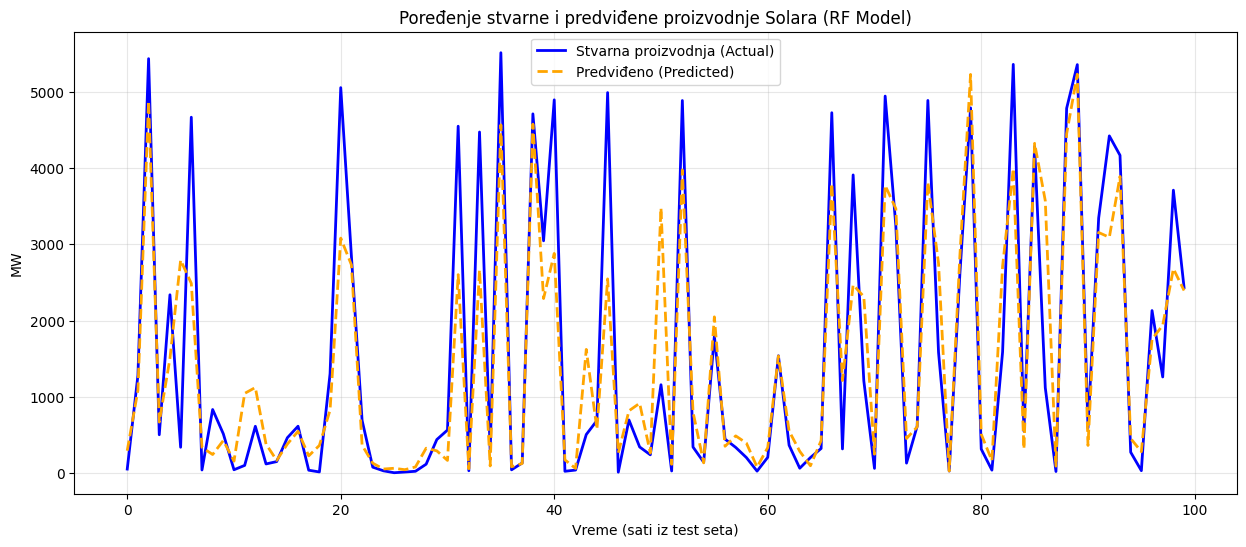

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Stvarna proizvodnja (Actual)', color='blue', linewidth=2)
plt.plot(y_pred[:100], label='Predviđeno (Predicted)', color='orange', linestyle='--', linewidth=2)

plt.title('Poređenje stvarne i predviđene proizvodnje Solara (RF Model)')
plt.xlabel('Vreme (sati iz test seta)')
plt.ylabel('MW')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df_final['hour'] = df_final['dt_iso'].dt.hour
df_final['month'] = df_final['dt_iso'].dt.month
df_final['day_of_week'] = df_final['dt_iso'].dt.dayofweek

features_wind = [
    'hour', 'month', 'day_of_week',

    'wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia',

    'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia',

    'wind_deg_Barcelona', 'wind_deg_Bilbao', 'wind_deg_Madrid', 'wind_deg_Seville', 'wind_deg_Valencia',

    'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia',

    'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia'
]

X = df_final[features_wind]
y_solar = df_final['generation wind onshore']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_solar.fit(X_train, y_train)

y_pred = rf_solar.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} MW")

importances = rf_solar.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_wind, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

R2 Score: 0.6104
MAE: 1508.71 MW
                 Feature  Importance
5      wind_speed_Madrid    0.089889
19       pressure_Bilbao    0.069572
1                  month    0.064036
21      pressure_Seville    0.056046
18    pressure_Barcelona    0.052669
27     humidity_Valencia    0.045263
25       humidity_Madrid    0.042094
22     pressure_Valencia    0.040556
20       pressure_Madrid    0.040324
2            day_of_week    0.037693
14       wind_deg_Bilbao    0.035179
26      humidity_Seville    0.034310
17     wind_deg_Valencia    0.034067
23    humidity_Barcelona    0.033575
24       humidity_Bilbao    0.032807
16      wind_deg_Seville    0.029847
13    wind_deg_Barcelona    0.029290
0                   hour    0.029043
15       wind_deg_Madrid    0.028535
7    wind_speed_Valencia    0.028035
4      wind_speed_Bilbao    0.026751
9      weather_id_Bilbao    0.021448
3   wind_speed_Barcelona    0.020642
6     wind_speed_Seville    0.018589
8   weather_id_Barcelona    0.017648
11   

<h2>XGBoost</h2>

In [ ]:
xgb_solar = xgb.XGBRegressor(
    n_estimators=500,       
    learning_rate=0.05,    
    max_depth=7,         
    subsample=0.8,         
    colsample_bytree=0.8,   
    random_state=42,
    n_jobs=-1
)

X = df_final[features_solar]
y_solar = df_final['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

xgb_solar.fit(X_train, y_train)

y_pred_xgb = xgb_solar.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print("--- XGBoost Rezultati Wind ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

xgb_importances = pd.DataFrame({
    'Feature': features_solar, 
    'Importance': xgb_solar.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_importances)

--- XGBoost Rezultati Wind ---
R2 Score: 0.8870
MAE: 361.58 MW
RMSE: 565.75 MW

XGBoost Feature Importance:
                 Feature  Importance
0                   hour    0.435228
22     humidity_Valencia    0.079910
20       humidity_Madrid    0.066439
21      humidity_Seville    0.048345
1                  month    0.033670
5      clouds_all_Madrid    0.032980
6     clouds_all_Seville    0.026750
18    humidity_Barcelona    0.025762
19       humidity_Bilbao    0.022137
7    clouds_all_Valencia    0.021349
16      pressure_Seville    0.019779
17     pressure_Valencia    0.019413
11    weather_id_Seville    0.018170
15       pressure_Madrid    0.017777
13    pressure_Barcelona    0.017645
14       pressure_Bilbao    0.017557
8   weather_id_Barcelona    0.015827
2            day_of_week    0.014465
12   weather_id_Valencia    0.014212
3   clouds_all_Barcelona    0.013986
10     weather_id_Madrid    0.013492
4      clouds_all_Bilbao    0.012778
9      weather_id_Bilbao    0.012329


In [ ]:

xgb_solar = xgb.XGBRegressor(
    n_estimators=500,       
    learning_rate=0.05,    
    max_depth=7,            
    subsample=0.8,         
    colsample_bytree=0.8,   
    random_state=42,
    n_jobs=-1
)

X = df_final[features_wind]
y_solar = df_final['generation wind onshore']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

xgb_solar.fit(X_train, y_train)

y_pred_xgb = xgb_solar.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse) 

print("--- XGBoost Rezultati Wind ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

xgb_importances = pd.DataFrame({
    'Feature': features_wind, 
    'Importance': xgb_solar.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_importances)

--- XGBoost Rezultati Wind ---
R2 Score: 0.6400
MAE: 1439.86 MW
RMSE: 1949.81 MW

XGBoost Feature Importance:
                 Feature  Importance
5      wind_speed_Madrid    0.143049
7    wind_speed_Valencia    0.055974
1                  month    0.050028
19       pressure_Bilbao    0.049592
22     pressure_Valencia    0.045138
4      wind_speed_Bilbao    0.044191
18    pressure_Barcelona    0.043950
21      pressure_Seville    0.043051
20       pressure_Madrid    0.040599
27     humidity_Valencia    0.033986
9      weather_id_Bilbao    0.032912
17     wind_deg_Valencia    0.032035
2            day_of_week    0.029719
25       humidity_Madrid    0.029375
14       wind_deg_Bilbao    0.027564
24       humidity_Bilbao    0.026502
10     weather_id_Madrid    0.026183
23    humidity_Barcelona    0.026097
8   weather_id_Barcelona    0.024955
12   weather_id_Valencia    0.024767
11    weather_id_Seville    0.024170
26      humidity_Seville    0.024050
6     wind_speed_Seville    0.022244
16

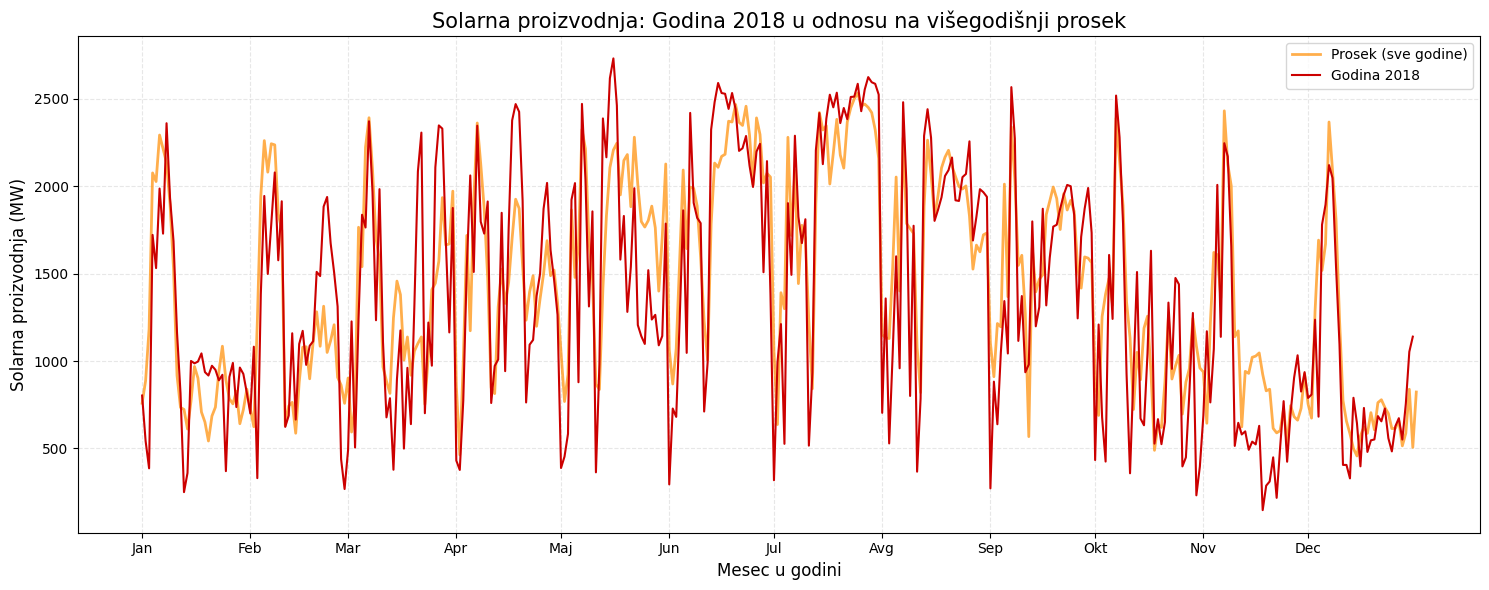

In [61]:


# 1. Priprema podataka
df_line = df_final.copy()
df_line['dt_iso'] = pd.to_datetime(df_line['dt_iso'], utc=True)
df_line['Year'] = df_line['dt_iso'].dt.year
df_line['Day_of_Year'] = df_line['dt_iso'].dt.dayofyear

# 2. Grupisanje na dnevni nivo
# Prvo dobijemo dnevni prosek za svaki specifičan dan u svakoj godini
df_daily = df_line.groupby(['Year', 'Day_of_Year'])['generation solar'].mean().reset_index()

# 3. Računanje opšteg proseka za sve tri godine (po danu u godini)
df_average = df_daily.groupby('Day_of_Year')['generation solar'].mean().reset_index()

# 4. Filtriramo jednu specifičnu godinu (npr. 2018 ili poslednju dostupnu)
izabrana_godina = df_daily['Year'].max()
df_specific_year = df_daily[df_daily['Year'] == izabrana_godina]

# 5. Crtanje
plt.figure(figsize=(15, 6))

# Linija proseka (Narandžasta) - deblja i malo prozirna da bude "pozadina"
plt.plot(df_average['Day_of_Year'], df_average['generation solar'], 
         color='#FF8C00', label='Prosek (sve godine)', linewidth=2, alpha=0.7)

# Linija specifične godine (Crvena) - istaknuta
plt.plot(df_specific_year['Day_of_Year'], df_specific_year['generation solar'], 
         color='#CC0000', label=f'Godina {izabrana_godina}', linewidth=1.5)

plt.title(f'Solarna proizvodnja: Godina {izabrana_godina} u odnosu na višegodišnji prosek', fontsize=15)
plt.xlabel('Mesec u godini', fontsize=12)
plt.ylabel('Solarna proizvodnja (MW)', fontsize=12)

# Podešavanje X ose na mesece
plt.xticks(ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Avg', 'Sep', 'Okt', 'Nov', 'Dec'])

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

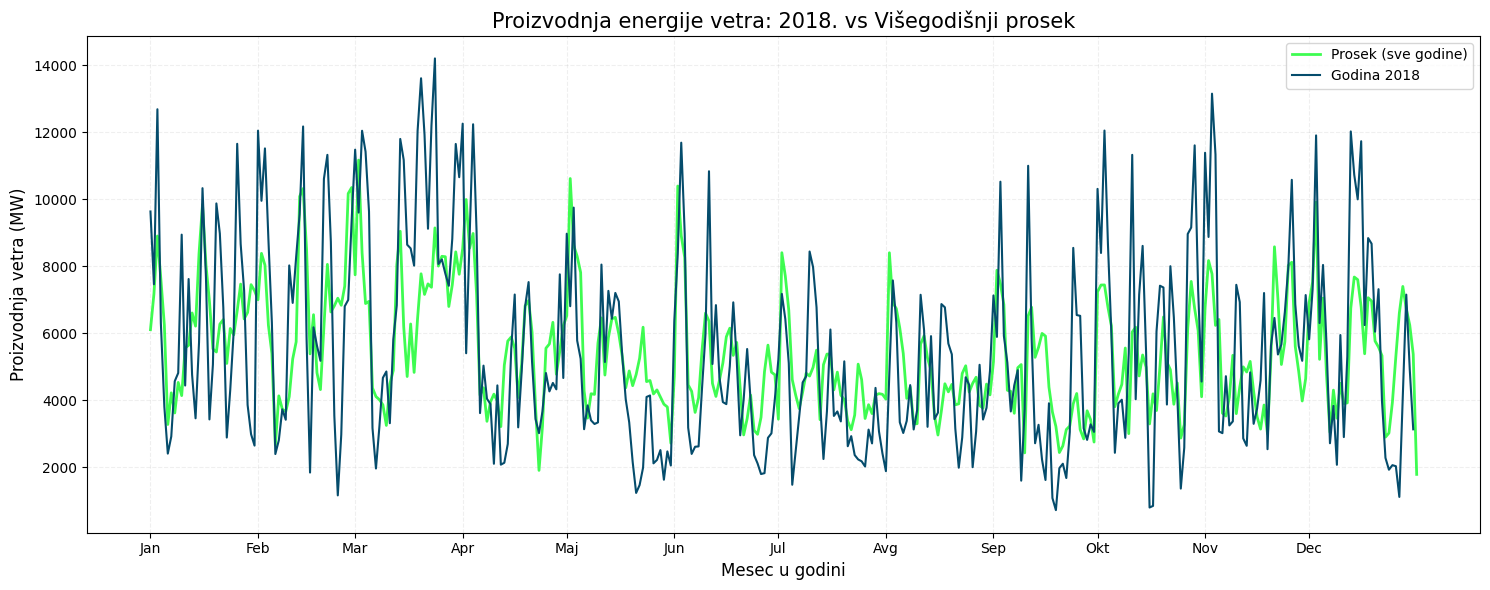

In [64]:

df_line_wind = df_final.copy()
df_line_wind['dt_iso'] = pd.to_datetime(df_line_wind['dt_iso'], utc=True)
df_line_wind['Year'] = df_line_wind['dt_iso'].dt.year
df_line_wind['Day_of_Year'] = df_line_wind['dt_iso'].dt.dayofyear

# 2. Grupisanje na dnevni nivo za vetar
df_daily_wind = df_line_wind.groupby(['Year', 'Day_of_Year'])['generation wind onshore'].mean().reset_index()

# 3. Računanje opšteg proseka za sve godine
df_avg_wind = df_daily_wind.groupby('Day_of_Year')['generation wind onshore'].mean().reset_index()

# 4. Filtriranje 2018. godine
df_2018 = df_daily_wind[df_daily_wind['Year'] == 2018]

# 5. Crtanje
plt.figure(figsize=(15, 6))

# Prosek (Svetlija siva) - "pozadinska" linija
plt.plot(df_avg_wind['Day_of_Year'], df_avg_wind['generation wind onshore'], 
         color="#0EFC26", label='Prosek (sve godine)', linewidth=2, alpha=0.8)

# Godina 2018 (Tamnoplava) - istaknuta linija
plt.plot(df_2018['Day_of_Year'], df_2018['generation wind onshore'], 
         color='#054C6C', label='Godina 2018', linewidth=1.5)

plt.title('Proizvodnja energije vetra: 2018. vs Višegodišnji prosek', fontsize=15)
plt.xlabel('Mesec u godini', fontsize=12)
plt.ylabel('Proizvodnja vetra (MW)', fontsize=12)

# Podešavanje X ose na mesece
plt.xticks(ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'Maj', 'Jun', 'Jul', 'Avg', 'Sep', 'Okt', 'Nov', 'Dec'])

plt.grid(True, linestyle='--', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

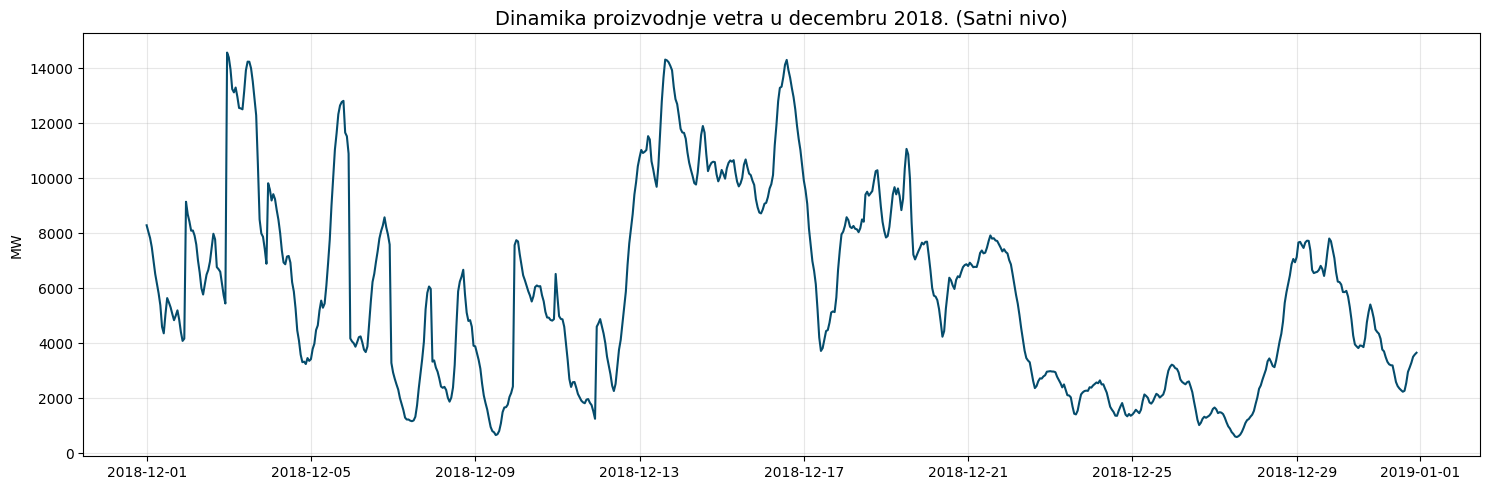

In [65]:
# Filtriramo decembar 2018.
df_december = df_line_wind[(df_line_wind['Year'] == 2018) & (df_line_wind['dt_iso'].dt.month == 12)]

plt.figure(figsize=(15, 5))
plt.plot(df_december['dt_iso'], df_december['generation wind onshore'], color='#054C6C', linewidth=1.5)

plt.title('Dinamika proizvodnje vetra u decembru 2018. (Satni nivo)', fontsize=14)
plt.ylabel('MW')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Uzeti su podaci u vremenskom rasponu od 9h do 18h da noćni sati ne bi uticali na grafik jer svakako ne utiču na proizvodnju solarne električne energije.

Broj redova nakon filtriranja: 14610


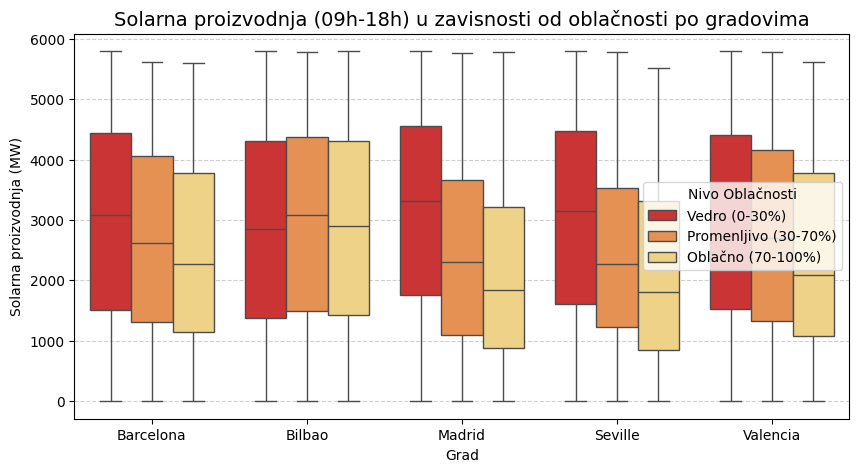

In [53]:
df_plot = df_final.copy()

df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)

df_plot.index = df_plot.index.tz_localize(None)
df_filtered = df_plot.between_time('09:00', '18:00')

print(f"Broj redova nakon filtriranja: {len(df_filtered)}")

if len(df_filtered) > 0:
    cloud_cols = ['clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia']
    
    df_melted = df_filtered.melt(id_vars=['generation solar'], 
                                 value_vars=cloud_cols, 
                                 var_name='Grad', 
                                 value_name='Oblacnost')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('clouds_all_', '')
    
    df_melted['Nivo Oblačnosti'] = pd.cut(df_melted['Oblacnost'], 
                                         bins=[-1, 30, 70, 101], 
                                         labels=['Vedro (0-30%)', 'Promenljivo (30-70%)', 'Oblačno (70-100%)'])
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Grad', y='generation solar', hue='Nivo Oblačnosti', data=df_melted, palette='YlOrRd_r')
    
    plt.title('Solarna proizvodnja (09h-18h) u zavisnosti od oblačnosti po gradovima', fontsize=14)
    plt.ylabel('Solarna proizvodnja (MW)')
    plt.xlabel('Grad')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Proveri kolonu 'dt_iso', i dalje nema podataka nakon filtriranja.")

Promene u oblačnosti zasnovane na merenjima u Madridu i Sevilji najviše utiču na proizvodnju električne energije. Možemo zaključiti da se u tim predelima nalaze najveći centri za proizvodnju solarne električne energije. Na proizvodnju solarne električne energije najmanje utiču promene u Bilbau.

Broj redova nakon filtriranja: 14610


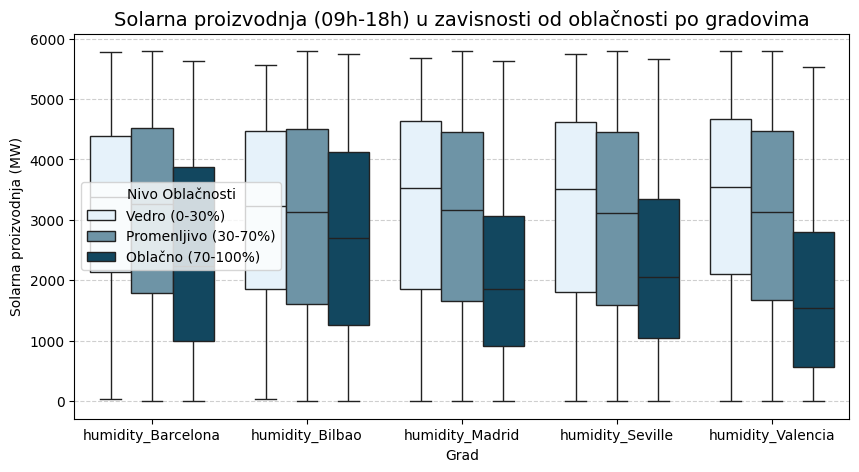

In [54]:
df_plot = df_final.copy()

custom_palette = ["#E3F2FD", "#6497B0", "#054C6C"]

df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)

df_plot.index = df_plot.index.tz_localize(None)
df_filtered = df_plot.between_time('09:00', '18:00')

print(f"Broj redova nakon filtriranja: {len(df_filtered)}")

if len(df_filtered) > 0:
    cloud_cols = ['humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia']
    
    df_melted = df_filtered.melt(id_vars=['generation solar'], 
                                 value_vars=cloud_cols, 
                                 var_name='Grad', 
                                 value_name='Oblacnost')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('clouds_all_', '')
    
    df_melted['Nivo Oblačnosti'] = pd.cut(df_melted['Oblacnost'], 
                                         bins=[-1, 30, 70, 101], 
                                         labels=['Vedro (0-30%)', 'Promenljivo (30-70%)', 'Oblačno (70-100%)'])
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Grad', y='generation solar', hue='Nivo Oblačnosti', data=df_melted, palette=custom_palette)
    
    plt.title('Solarna proizvodnja (09h-18h) u zavisnosti od oblačnosti po gradovima', fontsize=14)
    plt.ylabel('Solarna proizvodnja (MW)')
    plt.xlabel('Grad')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Proveri kolonu 'dt_iso', i dalje nema podataka nakon filtriranja.")

Vlažnost vazduha može takođe uticati na proizvodnju solarne električne energije, jer usled male pokrivenosti neba oblacima a veće vlažnosti vazduga, proizvodnja solarne električne energije može znatno da opadne

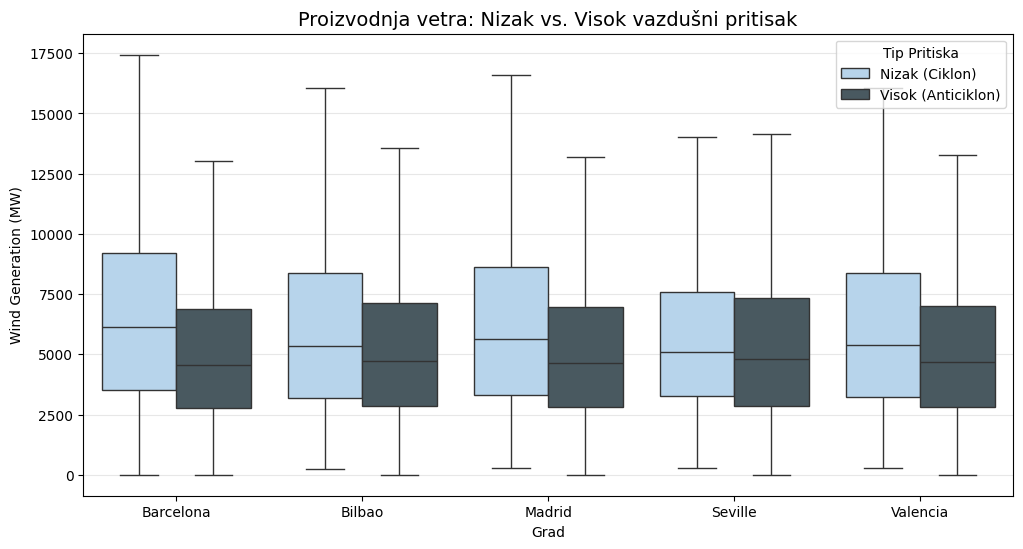

In [ ]:
# 1. Priprema i filtriranje (kao i do sada)
df_plot = df_final.copy()
df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)
df_plot.index = df_plot.index.tz_localize(None)

df_filtered = df_plot.copy() 

if len(df_filtered) > 0:
    pressure_cols = ['pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia']
    
    df_melted = df_filtered.melt(id_vars=['generation wind onshore'], 
                                 value_vars=pressure_cols, 
                                 var_name='Grad', 
                                 value_name='Pritisak')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('pressure_', '')

    df_melted['Tip Pritiska'] = pd.cut(df_melted['Pritisak'], 
                                       bins=[0, 1013, 1100], 
                                       labels=['Nizak (Ciklon)', 'Visok (Anticiklon)'])
    
    vazduh_palette = ["#AED5F4", "#455A64"] 

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Grad', y='generation wind onshore', hue='Tip Pritiska', 
                data=df_melted, palette=vazduh_palette, showfliers=False) 

    plt.title('Proizvodnja vetra: Nizak vs. Visok vazdušni pritisak', fontsize=14)
    plt.ylabel('Wind Generation (MW)')
    plt.grid(axis='y', alpha=0.3)
    
    plt.show()

Nizak vazdušni pritisak obično donosi nestabilno vreme (Cikloni), dok visok vazdušni pritisak (Anticikloni) obično donosi mirno vreme sa malo vetra. Primer: vazdušni pritisak u Sevilji uopšte nije u korelaciji sa proizvodnjom vetroenergije.

Bitno: vazdušni pritisak sam po sebi nije jasni pokazatelj na proizvodnju vetroenergije, ali promena vazdušnog pritiska (usled čega nastaje vetar) može biti odličan indikator kog modeli mogu da uoče.

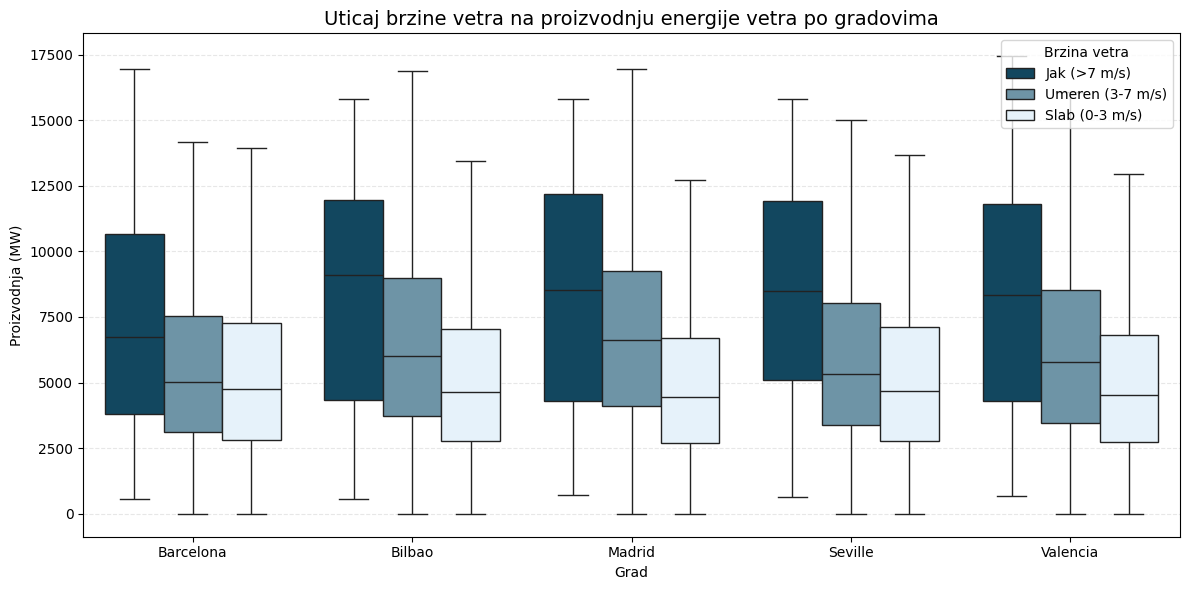

In [59]:
# 1. Priprema podataka
df_plot = df_final.copy()
df_plot['dt_iso'] = pd.to_datetime(df_plot['dt_iso'], utc=True)
df_plot.set_index('dt_iso', inplace=True)
df_plot.index = df_plot.index.tz_localize(None)

df_filtered = df_plot.copy() 

if len(df_filtered) > 0:
    # 2. Kolone za brzinu vetra
    wind_cols = ['wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia']
    
    # 3. Topljenje podataka
    df_melted = df_filtered.melt(id_vars=['generation wind onshore'], 
                                 value_vars=wind_cols, 
                                 var_name='Grad', 
                                 value_name='Brzina_vetra')
    
    df_melted['Grad'] = df_melted['Grad'].str.replace('wind_speed_', '')

    # 4. Kategorizacija - BITNO: binovi moraju odgovarati labelama
    # Za labelu "Jak" bin mora biti (7, 100], za "Slab" (0, 3]
    # Prvo pravimo logičan redosled kategorija
    df_melted['Kategorija Vetra'] = pd.cut(df_melted['Brzina_vetra'], 
                                           bins=[-1, 3, 7, 100], 
                                           labels=['Slab (0-3 m/s)', 'Umeren (3-7 m/s)', 'Jak (>7 m/s)'])

    # 5. Podešavanje palete i redosleda za vizualizaciju
    # Želimo: Jak (Tamna), Umeren (Srednja), Slab (Svetla)
    redosled = ['Jak (>7 m/s)', 'Umeren (3-7 m/s)', 'Slab (0-3 m/s)']
    wind_palette = ["#054C6C", "#6497B0", "#E3F2FD"] # Obrnut redosled boja (Tamna -> Svetla)

    # 6. Crtanje
    plt.figure(figsize=(12, 6)) # Prvo pravimo figuru
    
    sns.boxplot(x='Grad', y='generation wind onshore', 
                hue='Kategorija Vetra', 
                hue_order=redosled, # Redosled boxplotova: Jak, Umeren, Slab
                data=df_melted, 
                palette=wind_palette, 
                showfliers=False)

    plt.title('Uticaj brzine vetra na proizvodnju energije vetra po gradovima', fontsize=14)
    plt.ylabel('Proizvodnja (MW)')
    plt.xlabel('Grad')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(title='Brzina vetra', loc='upper right')
    
    plt.tight_layout()
    plt.show()
else:
    print("Nema podataka za prikaz.")

Mala razlika za 'Slab' i 'Umeren' vetar ukazuje na to da povećanje brzine vetra  uopšte ne utiče na proizvodnju ( > 3 ms) kada turbine zapravo počinju da proizvode energiju. Te pojave su najviše uočljive za gradove Barselonu i Sevilju, dok povećanje brzine vetra u Madridu i Bilbau najviše utiče na proizvodnju vetroenergije.